# Notebook Simulación Sistema BRT

## Librerias requeridas
---


In [1]:
import simpy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import math
import datetime
import copy
from random import randint, choice
import random
import csv 
import pandas as pd

## Definición de agentes
---

### Estación:

In [2]:
class Estacion:
    
    def __init__(self, nombre, idNodo):
        self.nombre = nombre
        self.colaRutas = {}
        self.idNodo = idNodo
        self.afluenciaLlegada = 0
        self.env = None
        self.ocupacionEnInstante = []
    
    def realizarAbordaje(self, maxUsuarios, ruta):
        # Determinar el mínimo entre la capacidad de la ruta y la cantidad de usaurios esperando
        cantidad = min(self.colaRutas[ruta], maxUsuarios)
        self.colaRutas[ruta] = self.colaRutas[ruta] - cantidad
        return cantidad
    
    def determinarUsuariosQueLlegan(self):
        numero_eventos = self.afluenciaLlegada
        tiempoEntreEventos = []
        tiemposAbsArr = []
        tiempoAbsoluto = 0
        _lambda = int(numero_eventos / 240)
        
        for i in range(numero_eventos):
            n = random.random()

            #Generar el tiempo entre eventos en base a la inversa de la función de probabilidad acumulada
            tiempoDesdeUltimoEvento = -math.log(1.0 - n) / _lambda
            tiempoAbsoluto = tiempoAbsoluto + tiempoDesdeUltimoEvento
            tiemposAbsArr.append(tiempoAbsoluto)

        arrEventosIntervalo = []
        contadorEventos = 1
        contadorIntervalos = 0

        #Contar las ocurrencias en cada intervalo 
        for i in range(len(tiemposAbsArr)):
            tiempoEvento = tiemposAbsArr[i]
            if tiempoEvento <= contadorIntervalos:
                contadorEventos += 1
            else:
                arrEventosIntervalo.append(contadorEventos)
                contadorIntervalos += 1
                contadorEventos = 1
                
        if len(arrEventosIntervalo) < 241:
            return self.determinarUsuariosQueLlegan()
        else:
            self.arrUsuariosEstacion = arrEventosIntervalo


---
### Bus


In [3]:
class Bus(object):
    
    def enParada(self):
        while len(self.paradas) > 0:
            #Si la estacion a la que se llega esta en la lista de paradas, parar
            paradaActualRecorrido = self.estaciones.pop(0)
            if(paradaActualRecorrido == self.paradas[0]):
                paradaActual = self.paradas.pop(0)
                self.bajarUsuarios()
                cantidad = paradaActual.realizarAbordaje(self.capacidad,self.nombre)
                self.capacidad = self.capacidad - cantidad
                # Definir tiempo de parada (1 minuto)
                yield self.env.timeout(1)
                # Guardar ocupacion del bus
                llave = diccionarioPromedioBuses.get(self.nombre)
                llave[self.env.now] = llave[self.env.now] + 242 - self.capacidad 
                yield self.env.process(self.enRecorrido())
            else:
                return self.env.process(self.enRecorrido())
        
        if(len(self.paradas) == 0 and not self.finalizado):
            self.finalizado = True
            self.ctrl.cantidadBusesGenerados[self.idRuta] = self.ctrl.cantidadBusesGenerados[self.idRuta] - 1
    
    def enRecorrido(self):
        while len(self.paradas) > 1:
            # definir tiempo para llegar a la estacion
            tiempoHastaSiguienteEstacion = randint(2,5)
            llave = diccionarioPromedioBuses.get(self.nombre)
            #Guardar la ocupacion del bus en cada instante del recorrido 
            if(self.env.now + tiempoHastaSiguienteEstacion < 240):
                for i in range(1, tiempoHastaSiguienteEstacion):                    
                    llave[self.env.now + i] = llave[self.env.now + i] + 242 -self.capacidad
                
            yield self.env.timeout(tiempoHastaSiguienteEstacion)
            yield self.env.process(self.enParada())
            
    def bajarUsuarios(self):
        usuariosABordo = 242 - self.capacidad 
        if (usuariosABordo != 0):
            usuariosQueBajan = randint(0, usuariosABordo)
            self.capacidad = self.capacidad + usuariosQueBajan
            
    def __init__(self, nombre, paradas, estaciones, idBus, idRuta, ctrl):
        self.env = None
        self.nombre = nombre
        self.estaciones = estaciones
        self.paradas = paradas
        self.capacidad = 242
        self.idBus = idBus
        self.idRuta = idRuta
        self.finalizado = False
        self.ctrl = ctrl


--- 

## Inicialización de datos

Para la inicialización de las estaciones y rutas se utilizaran los datos obtenidos desde el [portal de datos abiertos de Transmilenio](https://datosabiertos-transmilenio.hub.arcgis.com/), específicamente los datasets Rutas Troncales de Transmilenio, Estaciones Troncales de Transmilenio y el archivo StopTimes del GTFS estático del 2020-12-02. Con estos datos se han generado tres datasets que contengan únicamente la información referente a las rutas D20, H20 y 6 del sistema, únicamente en el tramo de la calle 80.

Las relaciones en los datos se dan de la siguiente manera:
 
* El dataset de estaciones contiene datos asociados a las estaciones del sistema, de los cuales se tomaran el numero, nombre, longitud y latitud.

* El dataset de rutas contiene datos referentes a los servicios que operan en el sistema, de estos solo se utilizara el nombre. 

* El archivo stoptimes del dataset GTFS contiene las horas de salida de un servicio, así como las paradas que efectúa y un secuencial que indica el numero de la parada del mismo.

* Con el fin de elaborar la matriz de paradas para una ruta, se asociara la ruta de stoptimes con la ruta del dataset de rutas. Así mismo, se asociara el numero de parada de este archivo con el numero de parada del dataset de estaciones.

In [4]:
estacionesArr = []
with open('./datasets/Estaciones.csv') as csv_estaciones:
    readerEstacion = csv.reader(csv_estaciones, delimiter=",")
    lines = 0
    for row in readerEstacion:
        if lines == 0:
            lines += 1
        else:
            estacionTemp = Estacion(row[4],row[23])
            estacionesArr.append(estacionTemp)
            lines += 1
    print(f'Se cargaron {lines-1} estaciones')

Se cargaron 13 estaciones


In [5]:
busesBaseArr = []
with open('./datasets/Rutas.csv') as csv_rutas:
    readerRutas = csv.reader(csv_rutas, delimiter=",")
    lines = 0
    for row in readerRutas:
        if lines == 0: 
            lines += 1
        else:
            busesBaseArr.append(row[8])
            lines += 1
    print(f'Se cargaron {lines-1} rutas')


Se cargaron 4 rutas


In [6]:
paradasH20 = []
paradasD20 = []
paradas6Portal = []
paradas6Polo = []
diccionarioPromedioBuses = {}
diccionarioBusesGenerados = {}
with open ('./datasets/StopTimes.csv') as csv_times:
    readerRutas = csv.reader(csv_times, delimiter=",")
    lines = 0
    for row in readerRutas:
        if lines == 0:
            lines += 1
        else:
            if(row[0] == 'H20'):
                for estacion in estacionesArr:
                    if estacion.idNodo == row[3]:
                        paradasD20.append(estacion)
                        estacion.colaRutas['H20'] = 0
            elif(row[0] == 'D20'): 
                for estacion in estacionesArr:
                    if estacion.idNodo == row[3]:
                        paradasH20.append(estacion)
                        estacion.colaRutas['D20'] = 0
            elif(row[0] == '6-1'):
                for estacion in estacionesArr:
                    if estacion.idNodo == row[3]:
                        paradas6Portal.append(estacion)
                        estacion.colaRutas['6 Polo'] = 0
                        estacion.colaRutas['6 Portal'] = 0
            lines += 1

paradas6Polo = paradas6Portal.copy()
paradas6Polo.reverse()



In [7]:
def agregarAfluenciaEstaciones():
    with open('./datasets/afluecia.csv') as data:
        readerAfluencia = csv.reader(data, delimiter=",")
        lines = 0
        for row in readerAfluencia:
            if lines == 0:
                lines += 1
            else:
                for estacion in estacionesArr:
                    if(estacion.idNodo == row[0]):
                        estacion.afluenciaLlegada = int(row[1])
                        estacion.determinarUsuariosQueLlegan()
                lines+=1
                

---
## Definición del Controlador


In [8]:
class Controlador(object):
    
    def generarBusesExpress(self,intervaloGeneracion):
        nuevoBus = None
        while True:
            if self.cantidadBusesGenerados[1] < self.maximoExpreso:
                nuevoBus = Bus('D20',paradasD20.copy(),paradas6Portal.copy(), self.idBus,0,self)
                self.cantidadBusesGenerados[1] = self.cantidadBusesGenerados[1] + 1
                nuevoBus.env = self.env
                self.idBus = self.idBus + 1
                nuevoBus.env.process(nuevoBus.enParada())
            if self.cantidadBusesGenerados[0] < self.maximoExpreso:
                nuevoBus = Bus('H20',paradasH20.copy(),paradas6Polo.copy(), self.idBus,2,self)
                self.cantidadBusesGenerados[0] = self.cantidadBusesGenerados[0] + 1
                nuevoBus.env = self.env
                self.idBus = self.idBus + 1
                nuevoBus.env.process(nuevoBus.enParada())
            
            yield self.env.timeout(intervaloGeneracion)
            
    def generarBusesFacil(self,intervaloGeneracion):
        nuevoBus = None
        while True:
            if self.cantidadBusesGenerados[3] < self.maximoFacil:
                nuevoBus = Bus('6 Portal',paradas6Portal.copy(),paradas6Portal.copy(), self.idBus,3,self)
                self.cantidadBusesGenerados[3] = self.cantidadBusesGenerados[3] + 1
                self.idBus = self.idBus + 1
                nuevoBus.env = self.env
                nuevoBus.env.process(nuevoBus.enParada())
            if self.cantidadBusesGenerados[2] < self.maximoFacil:
                nuevoBus = Bus('6 Polo',paradas6Polo.copy(),paradas6Polo.copy(), self.idBus,1,self)
                self.cantidadBusesGenerados[2] = self.cantidadBusesGenerados[2] + 1
                self.idBus = self.idBus + 1
                nuevoBus.env = self.env
                nuevoBus.env.process(nuevoBus.enParada())
            
            yield self.env.timeout(intervaloGeneracion)
            
    def generarUsuarios(self):
        while True:
            totalUsuarios = 0
            for estacion in estacionesArr:
                totalUsuariosEstacion = 0
                for ruta in estacion.colaRutas:
                    if len(estacion.colaRutas) == 4:
                        cant = int(estacion.arrUsuariosEstacion[self.env.now+1] / 4)
                    else:
                        cant = int(estacion.arrUsuariosEstacion[self.env.now+1] / 2)
                    estacion.colaRutas[ruta] = estacion.colaRutas[ruta] + cant 
                    totalUsuariosEstacion = estacion.colaRutas[ruta]+ totalUsuariosEstacion
                    totalUsuarios = totalUsuarios + totalUsuariosEstacion
                
                estacion.ocupacionEnInstante.append(totalUsuariosEstacion)
            minutes = self.env.now % 60
            hours = 4 + (int(self.env.now/60))
            time = datetime.datetime.strptime(str(hours)+":"+str(minutes), '%H:%M')
            self.timeArr.append(time)            
            self.ocupacionSistema.append(totalUsuarios)
            yield self.env.timeout(1)
            
    def monitorearOcupacionBuses(self):
        while True:
            diccionarioBusesGenerados['H20'][self.env.now] = self.cantidadBusesGenerados[0]
            diccionarioBusesGenerados['D20'][self.env.now] = self.cantidadBusesGenerados[1]
            diccionarioBusesGenerados['6 Polo'][self.env.now] = self.cantidadBusesGenerados[2]
            diccionarioBusesGenerados['6 Portal'][self.env.now] = self.cantidadBusesGenerados[3]
            yield self.env.timeout(1)
            
            
    def __init__(self, env, nombresRutas, intervaloGeneracionExpress, intervaloGeneracionFacil, maximoExpreso, maximoFacil):
        self.env = env
        self.nombreRutasArr = nombresRutas
        self.maximoExpreso = maximoExpreso
        self.maximoFacil = maximoFacil
        self.generacionUsuariosProc = self.env.process(self.generarUsuarios()) 
        self.generacionRutasFacilProc = self.env.process(self.generarBusesFacil(intervaloGeneracionFacil))
        self.generacionRutasExpressProc = self.env.process(self.generarBusesExpress(intervaloGeneracionExpress))
        self.monitorearOcupacionBuses = self.env.process(self.monitorearOcupacionBuses())
        self.idBus = 0
        self.timeArr = []
        self.ocupacionSistema = []
        self.cantidadBusesGenerados = [0,0,0,0]


---
## Metodos Auxiliares

In [9]:
def guardarOcupaciones(times, flag):
    for estacion in estacionesArr:
        nombreArchivo = 'temps/ocupacion_'+estacion.nombre+'.csv'
        if flag == 0:
            with open(nombreArchivo, 'w') as output:
                headers = ''
                vals = ''
                for i in range(len(estacion.ocupacionEnInstante)):
                    if i == 0:
                        headers = str(times[i])
                        vals = str(estacion.ocupacionEnInstante[i])
                    else:
                        headers = headers + ','+ str(times[i])
                        vals = vals + ',' + str(estacion.ocupacionEnInstante[i])
                output.write(headers)
                output.write('\n'+vals)
        else:
            with open(nombreArchivo, 'a') as output:
                vals = ''
                for i in range(len(estacion.ocupacionEnInstante)):
                    if i == 0:
                        vals = str(estacion.ocupacionEnInstante[i])
                    else:
                        vals = vals + ',' + str(estacion.ocupacionEnInstante[i])
                output.write('\n'+vals)
    nombreArchivo = 'temps/ocupacion_total.csv'
    if flag == 0:
        with open(nombreArchivo, 'w') as output:
            headers = ''
            vals = ''
            for i in range(len(ctrl.ocupacionSistema)):
                if i == 0:
                    headers = str(times[i])
                    vals = str(ctrl.ocupacionSistema[i])
                else:
                    headers = headers + ','+ str(times[i])
                    vals = vals + ',' + str(ctrl.ocupacionSistema[i])
            output.write(headers)
            output.write('\n'+vals)
    else:
        with open(nombreArchivo, 'a') as output:
            vals = ''
            for i in range(len(ctrl.ocupacionSistema)):
                if i == 0:
                    vals = str(ctrl.ocupacionSistema[i])
                else:
                    vals = vals + ',' + str(ctrl.ocupacionSistema[i])
            output.write('\n'+vals)

In [10]:
def guardarPromedios(flag):
    for key in diccionarioPromedioBuses:
        nombreArchivo = 'temps/promedios_Bus_'+ key +'.csv'        
        if flag == 0:
            with open(nombreArchivo, 'w') as output:
                headers = ''
                vals = ''
                for i in range(len(diccionarioPromedioBuses.get(key))):
                    if i == 0:
                        headers = str(i)
                        if diccionarioBusesGenerados.get(key)[i] != 0:
                            vals = str(int(diccionarioPromedioBuses.get(key)[i] / diccionarioBusesGenerados.get(key)[i]))
                        else:
                            vals = str(int(diccionarioPromedioBuses.get(key)[i]))
                    else:
                        headers = headers + ','+ str(i)
                        if diccionarioBusesGenerados.get(key)[i] != 0:
                            vals = vals + ',' + str(int( diccionarioPromedioBuses.get(key)[i] / diccionarioBusesGenerados.get(key)[i]))
                        else:
                            vals = vals + ',' + str(int( diccionarioPromedioBuses.get(key)[i]))
                output.write(headers)
                output.write('\n'+vals)
        else:
            with open(nombreArchivo, 'a') as output:
                vals = ''
                for i in range(len(diccionarioPromedioBuses[key])):
                    if i == 0:
                        if diccionarioBusesGenerados.get(key)[i] != 0 :
                            vals = str(int(diccionarioPromedioBuses.get(key)[i] / diccionarioBusesGenerados.get(key)[i]))
                        else:
                            vals = str(int(diccionarioPromedioBuses.get(key)[i]))
                    else:
                        if diccionarioBusesGenerados.get(key)[i] != 0 :
                            vals = vals + ',' + str(int( diccionarioPromedioBuses.get(key)[i] / diccionarioBusesGenerados.get(key)[i]))
                        else:
                            vals = vals + ',' + str(int( diccionarioPromedioBuses.get(key)[i]))
                output.write('\n'+vals)
    

In [11]:
def limpiarInstanciasEstacion():
    for estacion in estacionesArr:
        estacion.ocupacionEnInstante = []

In [12]:
def inicializarColas():
    for estacion in estacionesArr:
        if estacion in paradasH20:
            estacion.colaRutas['H20'] = 0
        if estacion in paradasD20:       
            estacion.colaRutas['D20'] = 0
        estacion.colaRutas['6 Polo'] = 0
        estacion.colaRutas['6 Portal'] = 0
        diccionarioPromedioBuses['H20'] = [0 for i in range(240)]
        diccionarioPromedioBuses['D20'] = [0 for i in range(240)]
        diccionarioPromedioBuses['6 Polo'] = [0 for i in range(240)]
        diccionarioPromedioBuses['6 Portal'] = [0 for i in range(240)]
        
        diccionarioBusesGenerados['H20'] = [0 for i in range(240)]
        diccionarioBusesGenerados['D20'] = [0 for i in range(240)]
        diccionarioBusesGenerados['6 Polo'] = [0 for i in range(240)]
        diccionarioBusesGenerados['6 Portal'] = [0 for i in range(240)]

---
## Creación de gráficas con los resultados obtenidos

In [13]:
def generarGraficaOcupacion(intervaloFacil,intervaloExpress,maximoFacil,maximoExpress):
    fig, axs = plt.subplots(7, 2,figsize=(18, 30),constrained_layout=True)
    for i in range(len(estacionesArr)):
        estacion = estacionesArr[i]
        nombreArchivo = 'temps/ocupacion_'+estacion.nombre+'.csv'
        df = pd.read_csv(nombreArchivo)
        hours = idx = pd.date_range('2020-01-01 04:00', '2020-01-01 07:59', freq = 'min')
        promedio = list(df.mean())
        desviacion = list(df.std())
        offsetPos = np.add(promedio,desviacion)
        offsetNeg = np.subtract(promedio,desviacion)

        axs[i%7,i%2].plot(hours,promedio)
        axs[i%7,i%2].fill_between(hours , offsetPos , offsetNeg, alpha=0.5)
        axs[i%7,i%2].xaxis.set_major_locator(mdates.MinuteLocator(byminute=[0,30]))
        h_fmt = mdates.DateFormatter('%H:%M')
        axs[i%7,i%2].xaxis.set_major_formatter(h_fmt)

        titulo = estacion.nombre 
        axs[i%7,i%2].set(title=titulo)

    nombreArchivo = 'temps/ocupacion_total.csv'
    df = pd.read_csv(nombreArchivo)
    hours = idx = pd.date_range('2020-01-01 04:00', '2020-01-01 07:59', freq = 'min')
    promedio = list(df.mean())
    desviacion = list(df.std())
    offsetPos = np.add(promedio,desviacion)
    offsetNeg = np.subtract(promedio,desviacion)

    axs[6,1].plot(hours,promedio)
    axs[6,1].fill_between(hours , offsetPos , offsetNeg, alpha=0.5)
    axs[6,1].xaxis.set_major_locator(mdates.MinuteLocator(byminute=[0,30]))
    h_fmt = mdates.DateFormatter('%H:%M')
    axs[6,1].xaxis.set_major_formatter(h_fmt)

    titulo = 'Ocupacion Total'
    axs[6,1].set(title=titulo)
    fig.suptitle('Ocupación por estación en hora pico \n' +
    '(Intervalo Fácil: '+ str(intervaloFacil) + ', Intervalo Express: '+ str(intervaloExpress)+')\n'+
                 '(Máximo Fácil: ' +str(maximoFacil)+ ', Máximo Express: '+ str(maximoExpress)+')')
        
    plt.savefig('imgs/OcupacionEstaciones/res_IF_'+str(intervaloFacil)+'_IE_'+str(intervaloExpress)+'_MF_'+str(maximoFacil)+'_ME_'+str(maximoExpress)+'.png')
    plt.clf()
    plt.close('all')
   

In [14]:
def generarGraficaBuses(intervaloFacil,intervaloExpress,maximoFacil,maximoExpress):
    fig, axs = plt.subplots(2, 2,figsize=(10, 10),constrained_layout=True)
    i = 0
    j = 0 
    for key in diccionarioPromedioBuses:
        nombreArchivo = 'temps/promedios_Bus_'+ key +'.csv'
        df = pd.read_csv(nombreArchivo)

        hours = idx = pd.date_range('2020-01-01 04:00', '2020-01-01 07:59', freq = 'min')
        promedio = list(df.mean())
        desviacion = list(df.std())
        offsetPos = np.add(promedio,desviacion)
        offsetNeg = np.subtract(promedio,desviacion)

        axs[i%2,j].plot(hours,promedio)
        axs[i%2,j].fill_between(hours , offsetPos , offsetNeg, alpha=0.5)
        axs[i%2,j].xaxis.set_major_locator(mdates.MinuteLocator(byminute=[0,30]))
        h_fmt = mdates.DateFormatter('%H:%M')
        axs[i%2,j].xaxis.set_major_formatter(h_fmt)

        titulo = key
        axs[i%2,j].set(title=titulo)
        i = i + 1 
        if i%2 == 0:
            j = j + 1
            
    fig.suptitle('Ocupación de los buses en hora pico. \n' +
    '(Intervalo Fácil: '+ str(intervaloFacil) + ', Intervalo Express: '+ str(intervaloExpress)+')\n'+
                 '(Máximo Fácil: ' +str(maximoFacil)+ ', Máximo Express: '+ str(maximoExpress)+')')
        
    plt.savefig('imgs/OcupacionBuses/res_IF_'+str(intervaloFacil)+'_IE_'+str(intervaloExpress)+'_MF_'+str(maximoFacil)+'_ME_'+str(maximoExpress)+'.png')
   
        
    plt.clf()
    plt.close('all')
    

---
## Inicio de la simulacion 

Intervalo F.: 1
  Intervalo E.: 1
    Max. F.: 1
      Max. E.: 1
      Max. E.: 2
      Max. E.: 3
      Max. E.: 4
      Max. E.: 5
      Max. E.: 6
      Max. E.: 7
      Max. E.: 8
      Max. E.: 9
      Max. E.: 10
    Max. F.: 2
      Max. E.: 1
      Max. E.: 2


KeyboardInterrupt: 

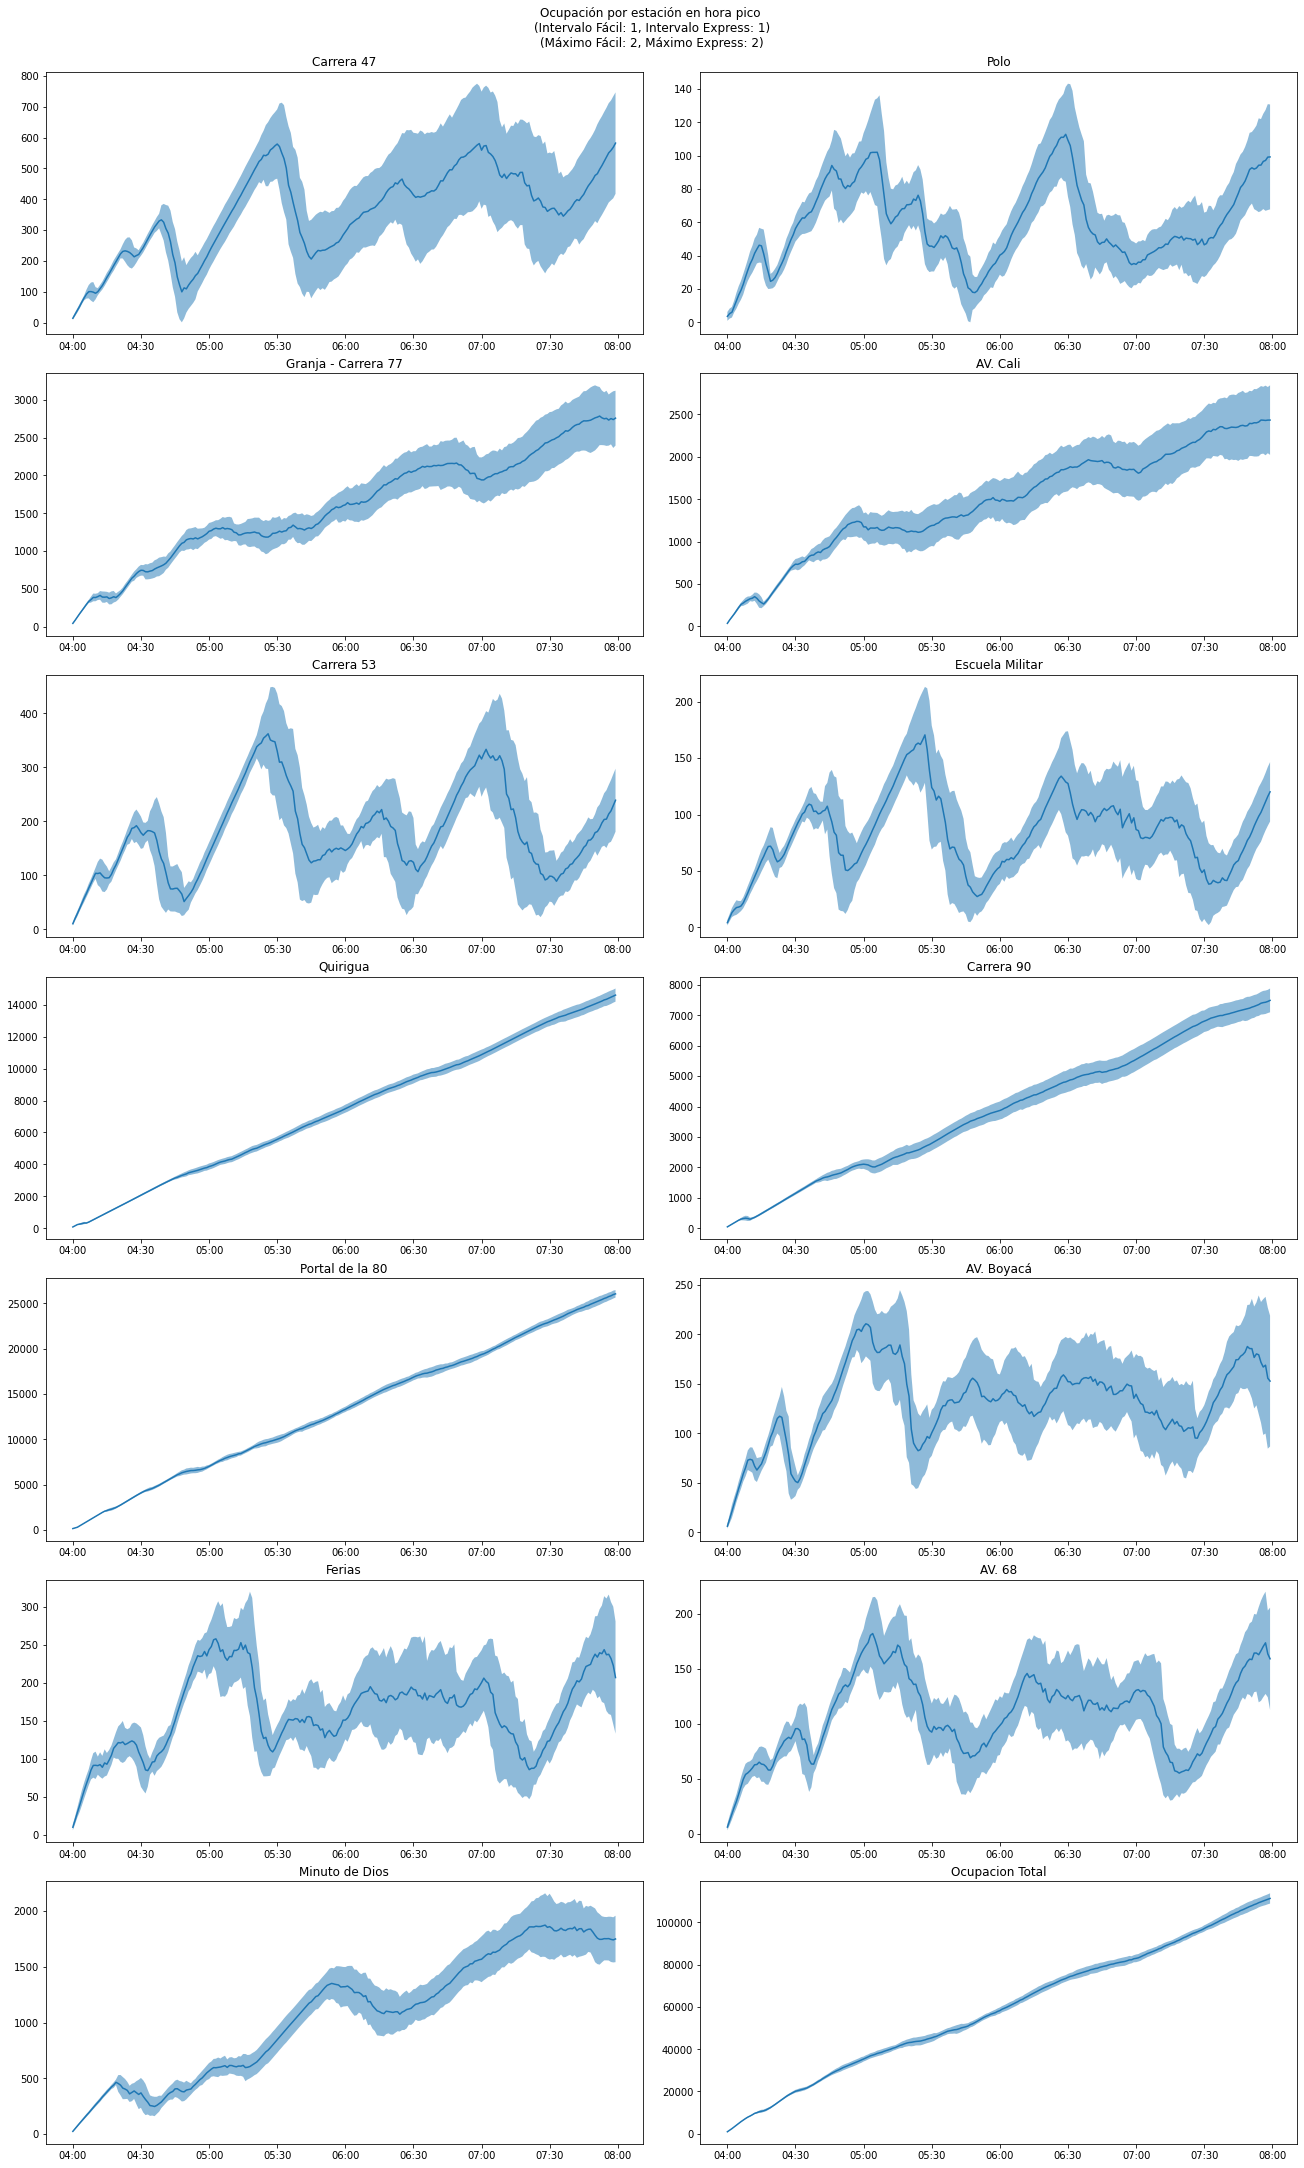

In [15]:
for iS in range(5):
    iS = iS + 1
    print("Intervalo F.: " + str(iS))
    for iiS in range(5):
        iiS = iiS + 1
        print("  Intervalo E.: " + str(iiS))
        for jS in range(10):
            jS = jS+1
            print("    Max. F.: " + str(jS))
            for jjS in range(10):
                jjS = jjS+1
                intervaloGeneracionFacil = iS
                intervaloGeneracionExpress = iiS
                maximoFacil = jS
                maximoExpress = jjS
                print("      Max. E.: " + str(jjS))
                # Simulacion 
                for kS in range(30):
                    limpiarInstanciasEstacion()
                    inicializarColas()
                    env = simpy.Environment()
                    ctrl = Controlador(env,busesBaseArr,intervaloGeneracionExpress,intervaloGeneracionFacil,maximoExpress,maximoFacil)
                    agregarAfluenciaEstaciones()
                    env.run(until=240)
                    guardarOcupaciones(ctrl.timeArr, kS)
                    guardarPromedios(kS)
                generarGraficaOcupacion(intervaloGeneracionFacil,intervaloGeneracionExpress, maximoFacil, maximoExpress)
                generarGraficaBuses(intervaloGeneracionFacil,intervaloGeneracionExpress, maximoFacil, maximoExpress)


